# LCA - Simple Demo

Here we implement a simple leaky, competing accumulator (LCA).

reference:
Usher, M., & McClelland, J. L. (2001).
The time course of perceptual choice: the leaky, competing accumulator model.
Psychological Review, 108(3), 550–592.
Retrieved from https://www.ncbi.nlm.nih.gov/pubmed/11488378


*Setup and Installation:*

In [40]:
%%capture
%pip install psyneulink
%pip install seaborn

In [41]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import psyneulink as pnl

sns.set_theme(style='white', context='poster', font_scale=.8, rc={"lines.linewidth": 2})
np.random.seed(0)

%matplotlib inline

In [42]:
# time step
time_step_size = .1

# network params
n_nodes = 3
sd = .2
leak = -1

# Weights
w_input = 1       # w_input (Input to decision layer)
w_cross = .1     # w_cross (Crosstalk input to decision layer)
w_inhib = 1       # w_inhib (Mutual inhibition among decision units)
w_self = 0     # w_self (Self recurrent conn. for each decision unit)
b_dec = 0    # b_dec (Bias input to decision units)

# Weight matrix from Input Layer --> Decision Layer
# Input weights are diagonals, cross weights are off diagonals
identity = np.matrix(np.eye(n_nodes))
mirror_identity = np.ones((n_nodes,n_nodes))
np.fill_diagonal(mirror_identity,0)
input_weights = identity * w_input + mirror_identity * w_cross

# initial states
initial_value = np.zeros((n_nodes,))
# initial_value = np.random.normal(size=(n_nodes,))

In [43]:
input_layer = pnl.TransferMechanism(
    input_shapes=n_nodes,                      # Number of units in input layer
    initial_value=np.zeros(n_nodes,),     # Initial input values
    name='INPUT LAYER'
)

decision_layer = pnl.LCAMechanism(
    input_shapes=n_nodes,                            # Number of units in input layer
    initial_value=initial_value,    # Initial input values
    time_step_size=time_step_size,     # Integration step size
    leak=leak,                         # Sets off diagonals to negative values
    self_excitation=w_self,           # Set diagonals to self excite
    competition=w_inhib,                 # Set off diagonals to inhibit
    function=pnl.Logistic(x_0=b_dec),
    noise=pnl.UniformToNormalDist(standard_deviation=sd).function,
    integrator_mode=True,
    name='DECISION LAYER'
)

model = pnl.Composition(
    reinitialize_mechanisms_when=pnl.Never()
)
model.add_linear_processing_pathway([input_layer, input_weights, decision_layer])

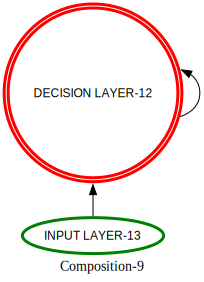

In [44]:
model.show_graph(output_fmt = 'jupyter')


In [45]:
input_pattern_set = list(np.eye(n_nodes))
num_time_steps = 80
trials = 2
total_trial_length = trials * num_time_steps

stimuli = np.concatenate([
    np.repeat(np.array([pattern_i]), num_time_steps, axis=0)
    for pattern_i in input_pattern_set
])

# assign inputs to input_layer (Origin Mechanism) for each trial
stim_list_dict = {input_layer: stimuli}

# print out the inputs
print(input_pattern_set)

# run the system
r = model.run(inputs=stim_list_dict, num_trials=total_trial_length)

[array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.])]


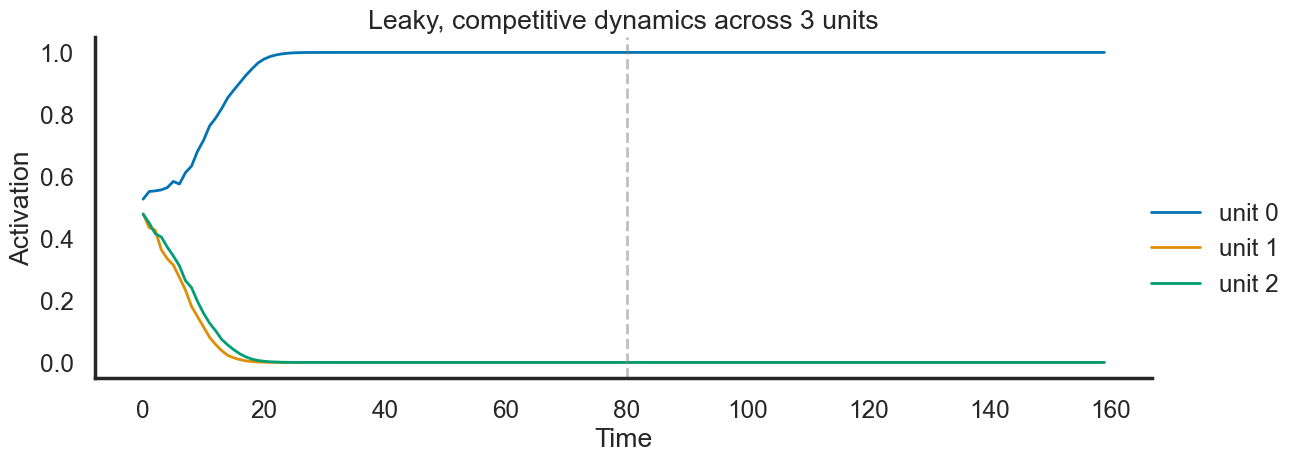

In [46]:
sns.set_palette("colorblind")
# compute event bonds
bonds = np.arange(num_time_steps, total_trial_length, num_time_steps)

# fetch activities (n_time_points x n_neurons)
acts = np.squeeze(model.results)

# plot the dynamics
f, ax = plt.subplots(1,1, figsize = (12,5))

ax.plot(acts)

ax.set_title(f'Leaky, competitive dynamics across {n_nodes} units')
ax.set_xlabel('Time')
ax.set_ylabel('Activation')
f.legend([f'unit {i}' for i in range(n_nodes)], frameon=False, bbox_to_anchor=(1.1,.6))

for bond in bonds:
    ax.axvline(bond, color='grey', alpha=.5, linestyle='--')

f.tight_layout()
sns.despine()

In [ ]:
# /TODO: Fix when RecurrentTransferMechanism confusion is resolved